In [1]:
import pandas as pd
import numpy as np
import QuantLib as ql
import matplotlib.pyplot as plt
from typing import Iterable, Tuple, Dict, List, Optional
from scipy.optimize import least_squares
import logging
from dataclasses import dataclass, field
import math
print(ql.__version__)


1.39


In [2]:
today = ql.Date(25, ql.July, 2025)  # Set the evaluation date
ql.Settings.instance().evaluationDate = today


# import market data
mkt = pd.read_csv("SOFR_OIS_Fut_data.csv", index_col='Ticker')["2025_07_25"]


# -----------------------------------
# 1. define calendar, convention, day count, and SOFR index 
# -----------------------------------
calendar   = ql.UnitedStates(ql.UnitedStates.FederalReserve)
day_count  = ql.Actual360()
sofr_idx   = ql.Sofr()


# -----------------------------------
# 2. RateHelper List
# -----------------------------------
helpers = []

# 2.1 Overnight Pillar
on_rate = mkt["USSON Curncy"] / 100.0  
helpers.append(
    ql.OISRateHelper(
        0,                                   # settlementDays = 0 (ON)
        ql.Period(1, ql.Days),
        ql.QuoteHandle(ql.SimpleQuote(on_rate)),
        sofr_idx
    )
)

# 2.2 OIS — 1D to 1Y
ois_map = {   
    "USSOA Curncy":  ("1M", ql.QuoteHandle(ql.SimpleQuote(mkt["USSOA Curncy"]/100))),
    "USSOB Curncy":  ("2M", ql.QuoteHandle(ql.SimpleQuote(mkt["USSOB Curncy"]/100))),
    "USSOC Curncy":  ("3M", ql.QuoteHandle(ql.SimpleQuote(mkt["USSOC Curncy"]/100))),
    "USSOF Curncy":  ("6M", ql.QuoteHandle(ql.SimpleQuote(mkt["USSOF Curncy"]/100))),
    "USSOI Curncy":  ("9M", ql.QuoteHandle(ql.SimpleQuote(mkt["USSOI Curncy"]/100))),
    "USSO1 Curncy":  ("1Y", ql.QuoteHandle(ql.SimpleQuote(mkt["USSO1 Curncy"]/100))),
    "USSO1F Curncy": ("18M",ql.QuoteHandle(ql.SimpleQuote(mkt["USSO1F Curncy"]/100))),
}

for tkr,(tenor,qh) in ois_map.items():
    helpers.append(
        ql.OISRateHelper(
            2,                               # settlementDays (OIS = 2)
            ql.Period(tenor),
            qh,
            sofr_idx
        )
    )

# 2.3 CME 3-Month SOFR Futures
fut_tickers = ["SFRU5 Comdty","SFRZ5 Comdty","SFRH6","SFRM6","SFRU6","SFRZ6"]


for tkr in fut_tickers:
    price = mkt[tkr]            
    imm_dt= ql.IMM.date(tkr[3:5])
    helpers.append(
        ql.FuturesRateHelper(
            ql.QuoteHandle(ql.SimpleQuote(price)),
            imm_dt,
            3,                          # contract tenor 3M
            calendar,
            ql.ModifiedFollowing,
            False,
            day_count
        )
    )

# 2.4 Long end 2Y – 30Y SOFR OIS Swaps
swap_ois_tenors = {
    "USSO2 Curncy": 2,
    "USSO3 Curncy": 3,
    "USSO5 Curncy": 5,
    "USSO7 Curncy": 7,
    "USSO10 Curncy":10,
    "USSO15 Curncy":15,
    "USSO20 Curncy":20,
    "USSO30 Curncy":30,
}


for tkr,yrs in swap_ois_tenors.items():
    helpers.append(
        ql.OISRateHelper(
            2, # settlementDays (OIS = 2)
            ql.Period(yrs, ql.Years),
            ql.QuoteHandle(ql.SimpleQuote(mkt[tkr]/100)),
            sofr_idx,                   
        )
    )

# --------------------------------------------------
# 3. PiecewiseYieldCurve 
# --------------------------------------------------

# Sort helpers by their latest date to ensure the curve is built correctly
helpers = sorted(helpers, key=lambda h: h.latestDate())
for i in range(len(helpers)-1):
    assert helpers[i].latestDate() < helpers[i+1].latestDate(), "pillar dates not increasing"


curve = ql.PiecewiseLogCubicDiscount(
            0,          # settlementDays
            calendar,
            helpers,
            day_count
        )
curve.enableExtrapolation()

discount_curve = ql.YieldTermStructureHandle(curve)

# --------------------------------------------------
# 4. Output：discount factors / B(0,T) / Forward rates
# --------------------------------------------------
def curve_table(curve, intervals):
    rows=[]
    today = curve.referenceDate()
    for d in intervals:
        tdate = today + d
        t     = curve.dayCounter().yearFraction(today, tdate)
        zeror = curve.zeroRate(tdate, day_count, ql.Compounded, ql.Annual).rate()
        df    = curve.discount(tdate)
        rows.append([tdate.ISO(), round(t,4), round(zeror*100,4), round(df,8)])
    return pd.DataFrame(rows, columns=["Date","YearFrac","ZeroRate(%)","DF"])

grid = [ql.Period(i, ql.Days)  for i in range(1, 365*30)] 
  

curve_df = curve_table(curve, grid)
display(curve_df.head(12))   

,Date,YearFrac,ZeroRate(%),DF
0,2025-07-26,0.0028,4.4568,0.999879
1,2025-07-27,0.0056,4.4563,0.999758
2,2025-07-28,0.0083,4.4556,0.999637
3,2025-07-29,0.0111,4.4546,0.999516
4,2025-07-30,0.0139,4.4536,0.999395
5,2025-07-31,0.0167,4.4524,0.999274
6,2025-08-01,0.0194,4.4512,0.999154
7,2025-08-02,0.0222,4.4500,0.999033
8,2025-08-03,0.0250,4.4489,0.998912
9,2025-08-04,0.0278,4.4477,0.998792


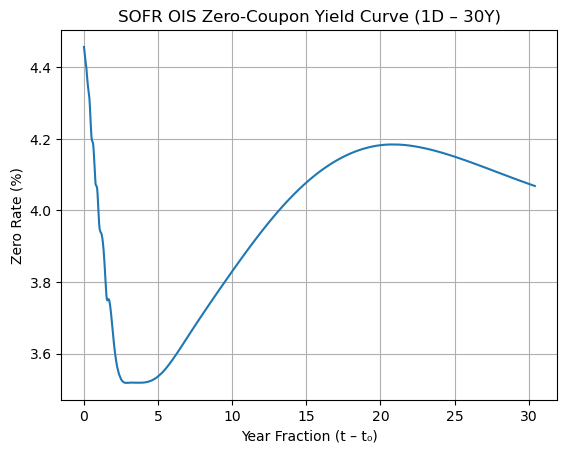

In [3]:
# Plot the Zero‐Rate curve
plt.figure()
plt.plot(curve_df["YearFrac"], curve_df["ZeroRate(%)"])
plt.xlabel("Year Fraction (t – t₀)")
plt.ylabel("Zero Rate (%)")
plt.title("SOFR OIS Zero‑Coupon Yield Curve (1D – 30Y)")
plt.grid(True)
plt.show()

In [4]:
# Repricing error check
max_err = 0.0
for h in helpers:
    err = h.quote().value() - h.impliedQuote()  
    max_err = max(max_err, abs(err))
print("Max repricing erro =", max_err)
assert max_err < 0.000001, "Anchor price not closed!" # 0.01bp
print("Repricing error check passed!")


# Monotonic DF > 0 check
dates = [calendar.advance(today, ql.Period(i, ql.Months)) for i in range(1, 360)]
dfs = [curve.discount(d) for d in dates]
assert all(dfs[i] >= dfs[i+1] for i in range(len(dfs)-1)), "Df not monotonic"
assert all(df > 0 for df in dfs), "Negative df found!"
print("Monotonic discount factors check passed!")


# Short-end cash no-arbitrage check
settlement_days = 2
settle_date = calendar.advance(today, ql.Period(settlement_days, ql.Days))
d0 = settle_date
maturity_date = calendar.advance(settle_date, ql.Period("1M"))
d1 = maturity_date
alpha = curve.dayCounter().yearFraction(d0, d1)
fwd = (curve.discount(d0) - curve.discount(d1)) / (alpha * curve.discount(d1)) 
ois1m = mkt["USSOA Curncy"]/100
diff_bp = (fwd - ois1m)*1e4
print("Fwd(ON,1M) – OIS1M = %.2f bp" % diff_bp)
assert abs(diff_bp) < 0.5, "Short end cash no-arbitrage broken!"  # 0.5bp tolerance
print("Short-end cash no-arbitrage check passed!")


Max repricing erro = 2.2720314518664964e-10
Repricing error check passed!
Monotonic discount factors check passed!
Fwd(ON,1M) – OIS1M = -0.00 bp
Short-end cash no-arbitrage check passed!


In [5]:
################################################################################
# 1. ── Black‑76 market PV helper
################################################################################

def black_pv(discount_curve: ql.YieldTermStructureHandle,
             opt_mat: str,
             swap_tenor: str,
             sigma_b: float,
             payer: bool = True) -> float:
    """Return Black‑76 ATM swaption PV using the provided Black vol (pct)."""
    sofr     = ql.Sofr(discount_curve)                      # 内置 + 曲线
    
    today = discount_curve.referenceDate()
    opt_mat = ql.Period(opt_mat)  
    exercise_date = calendar.advance(today, opt_mat)
    effective_date = calendar.advance(exercise_date, ql.Period(2, ql.Days))  
    days_to_start = effective_date - today     
    fwdStart = ql.Period(int(days_to_start), ql.Days)

    swap_tenor = ql.Period(swap_tenor)  

    # 建 ATM swap，起始 = today+opt_mat+2bd
    swap = ql.MakeOIS(
        swap_tenor, sofr,
        fixedRate=None, # None => ATM
        fwdStart=fwdStart, # effective date: usually T+2
        discountingTermStructure=discount_curve
    )

    exercise = ql.EuropeanExercise(exercise_date)
    swpt     = ql.Swaption(swap, exercise)

    vol = ql.QuoteHandle(ql.SimpleQuote(sigma_b))  
    swpt.setPricingEngine(ql.BlackSwaptionEngine(discount_curve, vol))
    return swpt.NPV() * (1 if payer else -1)

################################################################################
# 2. ── Hull‑White model PV helper
################################################################################


def HW_pv(discount_curve: ql.YieldTermStructureHandle,
          opt_mat: str, 
          swap_tenor: str, 
          a: float,
          sigma: float,
          payer: bool = True) -> float:
    """Jamshidian PV under HW(a,sigma)."""
    # 每次生成新模型，速度足够
    sofr     = ql.Sofr(discount_curve) 

    today = discount_curve.referenceDate()
    opt_mat = ql.Period(opt_mat)  
    exercise_date = calendar.advance(today, opt_mat)
    effective_date = calendar.advance(exercise_date, ql.Period(2, ql.Days)) 
    days_to_start = effective_date - today     
    fwdStart = ql.Period(int(days_to_start), ql.Days)
    swap_tenor = ql.Period(swap_tenor)  

    hw = ql.HullWhite(discount_curve, a, sigma)
    engine = ql.JamshidianSwaptionEngine(hw, discount_curve)
    
    # Create ATM Swaption
    swap = ql.MakeOIS(
        swap_tenor, sofr,
        fixedRate=None, # None => ATM
        fwdStart=fwdStart, # effective date
        discountingTermStructure=discount_curve
    )
    exercise = ql.EuropeanExercise(exercise_date)
    swpt = ql.Swaption(swap, exercise)
    swpt.setPricingEngine(engine)

    return swpt.NPV() * (1 if payer else -1)




def train_test_split(df: pd.DataFrame, split_by: str, thresh: str):
    np.random.seed(42) 
    if split_by == "ratio":
        ratio = float(thresh)
        mask = pd.Series(np.random.rand(len(df)) < ratio, index=df.index)
    elif split_by == "opt":
        pth = ql.Period(thresh)
        mask = df["opt_mat"].apply(lambda x: ql.Period(str(x)) <= pth)
    else:
        pth = ql.Period(thresh)
        mask = df["swap_tenor"].apply(lambda x: ql.Period(str(x)) <= pth)

    in_sample_filter = lambda r: mask.loc[r.name]
    train_df = df[df.apply(in_sample_filter, axis=1)]
    test_df = df[~df.apply(in_sample_filter, axis=1)]

    train_df = train_df.copy()
    test_df = test_df.copy()

    return train_df, test_df



def Calibrate_HW(discount_curve: ql.YieldTermStructureHandle,
                  train_df: pd.DataFrame,
                  test_df: pd.DataFrame,
                  initial_params: Tuple[float, float] = (0.03, 0.01),
                  bounds: Tuple[Tuple[float, float]] = ((0.01, 0.01), (0.1, 0.05))) -> Tuple[float, float]:
    
    train_df['mkt_pv'] = train_df.apply(
    lambda r: black_pv(discount_curve, r.opt_mat, r.swap_tenor, r.sigmaB_pct*1e-2),
    axis=1
    )

    """Calibrate Hull-White model parameters a and sigma."""
    def residuals(params):
        a, sigma = params
        mdl = train_df.apply(
            lambda r: HW_pv(discount_curve, r.opt_mat, r.swap_tenor, a, sigma), axis=1
        )
        diff_bp = (mdl.values - train_df.mkt_pv.values) * 1e4  # → bp
        return diff_bp

    res = least_squares(residuals, initial_params,
                        bounds=bounds, xtol=1e-10, ftol=1e-10)
    a_opt, sigma_opt = res.x
    rmse = np.sqrt(np.mean(res.fun**2))
    print(f"Calibrated a={a_opt:.6f}, sigma={sigma_opt:.6f}, RMSE={rmse:.3f} bp")

    # Test set performance
    if 'mkt_pv' not in test_df.columns:
        test_df = test_df.copy()
        test_df['mkt_pv'] = test_df.apply(
            lambda r: black_pv(discount_curve, r.opt_mat, r.swap_tenor, r.sigmaB_pct*1e-2),
            axis=1
        )
    test_pred = test_df.apply(
        lambda r: HW_pv(discount_curve, r.opt_mat, r.swap_tenor, a_opt, sigma_opt), axis=1
    )
    test_diff_bp = (test_pred.values - test_df.mkt_pv.values) * 1e4
    test_rmse = np.sqrt(np.mean(test_diff_bp**2))
    print(f"Test RMSE={test_rmse:.3f} bp")
    return a_opt, sigma_opt


#  Gaussian Short Term Rate One Factor model
def GSR_pv(discount_curve: ql.YieldTermStructureHandle,
          opt_mat: str, 
          swap_tenor: str, 
          a: float,
          sigma_vec: List[float],
          vol_times: List[ql.Period],
          payer: bool = True) -> float:
    
    vol_dates = ql.DateVector([calendar.advance(discount_curve.referenceDate(), p) for p in vol_times])

    sigma_handles = ql.QuoteHandleVector(
        [ql.QuoteHandle(ql.SimpleQuote(v)) for v in sigma_vec]
    )

    # 3) reversion 也要 QuoteHandleVector（这里只有一段）
    rev_handles = ql.QuoteHandleVector(
        [ql.QuoteHandle(ql.SimpleQuote(a))]
    )


    sofr = ql.Sofr(discount_curve)
    today = discount_curve.referenceDate()
    opt_mat = ql.Period(opt_mat)  
    exercise_date = calendar.advance(today, opt_mat)
    effective_date = calendar.advance(exercise_date, ql.Period(2, ql.Days))
    days_to_start = effective_date - today     
    fwdStart = ql.Period(int(days_to_start), ql.Days)
    swap_tenor = ql.Period(swap_tenor)

    # Create the GSR model
    gsr = ql.Gsr(discount_curve,
                 vol_dates,
                 sigma_handles,
                 rev_handles,)
    engine = ql.Gaussian1dSwaptionEngine(gsr)

    # Create ATM Swaption
    swap = ql.MakeOIS(
        swap_tenor, sofr,
        fixedRate=None, # None => ATM
        fwdStart=fwdStart, # effective date
        discountingTermStructure=discount_curve
    )
    exercise = ql.EuropeanExercise(exercise_date)
    swpt = ql.Swaption(swap, exercise)
    swpt.setPricingEngine(engine)


    return swpt.NPV() * (1 if payer else -1)

def Calibrate_GSR(discount_curve: ql.YieldTermStructureHandle,
                  train_df: pd.DataFrame,
                  test_df: pd.DataFrame,
                  vol_times = [ql.Period("1Y"), ql.Period("2Y"), ql.Period("5Y"), ql.Period("10Y")],
                  initial_params = (0.03, 0.01, 0.01, 0.01, 0.01, 0.01),
                  bounds = ((0.001, 0.001, 0.001, 0.001, 0.001, 0.001), (0.1, 0.05, 0.05, 0.05, 0.05, 0.05))) -> Tuple[float, List[float]]:
    

    train_df['mkt_pv'] = train_df.apply(
        lambda r: black_pv(discount_curve, r.opt_mat, r.swap_tenor, r.sigmaB_pct*1e-2),
        axis=1
    )

    """Calibrate GSR model parameters a and sigma."""
    def residuals(params):
        a = params[0]
        sigma_vec = params[1:]
        mdl = train_df.apply(
            lambda r: GSR_pv(discount_curve, r.opt_mat, r.swap_tenor, a, sigma_vec, vol_times), axis=1
        )
        diff_bp = (mdl.values - train_df.mkt_pv.values) * 1e4  # → bp
        return diff_bp

    res = least_squares(residuals, initial_params,
                        bounds=bounds, xtol=1e-10, ftol=1e-10)
    a_opt = res.x[0]
    sigma_opt = res.x[1:]
    rmse = np.sqrt(np.mean(res.fun**2))
    print(f"Calibrated a={a_opt:.6f}, sigma={sigma_opt}, RMSE={rmse:.3f} bp")

    # Test set performance
    if 'mkt_pv' not in test_df.columns:
        test_df = test_df.copy()
        test_df['mkt_pv'] = test_df.apply(
            lambda r: black_pv(discount_curve, r.opt_mat, r.swap_tenor, r.sigmaB_pct*1e-2),
            axis=1
        )
    test_pred = test_df.apply(
        lambda r: GSR_pv(discount_curve, r.opt_mat, r.swap_tenor, a_opt, sigma_opt, vol_times), axis=1
    )
    test_diff_bp = (test_pred.values - test_df.mkt_pv.values) * 1e4
    test_rmse = np.sqrt(np.mean(test_diff_bp**2))
    print(f"Test RMSE={test_rmse:.3f} bp")

    return a_opt, sigma_opt






In [6]:
df = pd.read_csv("OIS_Swaption_Vol_20250725.csv", index_col=0)
df_long = df.reset_index().melt(id_vars='index', var_name='swap_tenor', value_name='sigmaB_pct')
black_df = df_long.rename(columns={'index': 'opt_mat'})
black_df

,opt_mat,swap_tenor,sigmaB_pct
0,1M,1Y,5.03
1,2M,1Y,5.25
2,3M,1Y,5.42
3,6M,1Y,5.75
4,9M,1Y,5.89
...,...,...,...
295,10Y,30Y,5.32
296,12Y,30Y,5.18
297,15Y,30Y,4.96
298,20Y,30Y,4.63


In [7]:
train_df, test_df = train_test_split(black_df, split_by="ratio", thresh="0.8")
a_HW_opt, sigma_HW_opt = Calibrate_HW(discount_curve, train_df, test_df, initial_params=(0.03, 0.01), bounds=((1e-4, 1e-4),# lower bounds
                                                                                                (0.1, 0.1))) # upper bounds


Calibrated a=0.023286, sigma=0.002850, RMSE=8.906 bp
Test RMSE=8.858 bp


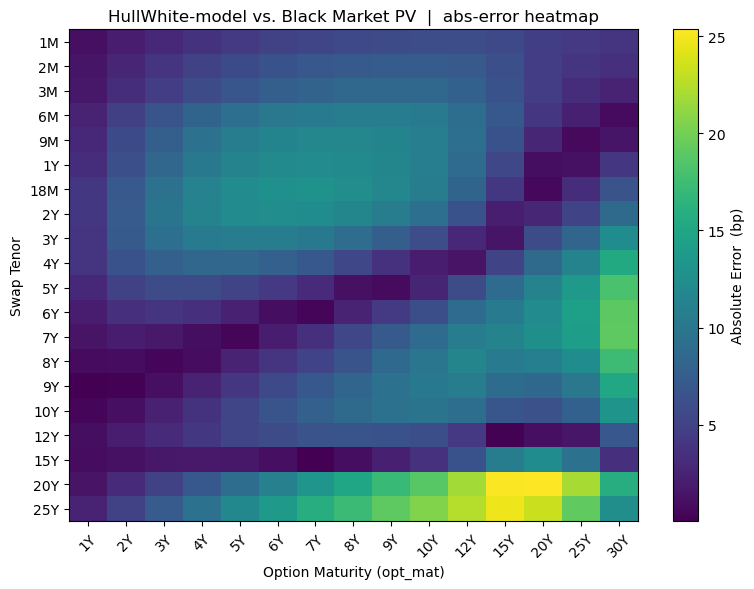

In [22]:

black_df["abs_err_bp(HW)"] = black_df.apply(
        lambda r: abs(
            HW_pv(discount_curve, r.opt_mat, r.swap_tenor, a_HW_opt, sigma_HW_opt) -
            black_pv(discount_curve, r.opt_mat, r.swap_tenor, r.sigmaB_pct*1e-2)
        ) * 1e4,    # → bp
        axis=1
    ).copy()    

heat = black_df.pivot_table(index="opt_mat",columns="swap_tenor",values="abs_err_bp(HW)")
opt_mat_order = ["1M", "2M", "3M", "6M", "9M", "1Y", "18M", "2Y", "3Y",
 "4Y", "5Y", "6Y", "7Y", "8Y", "9Y", "10Y", "12Y", "15Y", "20Y", "25Y"]
swap_tenor_order = [ "1Y",  "2Y", "3Y", "4Y", "5Y", "6Y", "7Y", "8Y", "9Y",
 "10Y", "12Y", "15Y", "20Y", "25Y", "30Y"]
heat = heat.reindex(opt_mat_order)
heat = heat.reindex(columns=swap_tenor_order)


fig, ax = plt.subplots(figsize=(8,6))
im = ax.imshow(heat.values, aspect="auto")
ax.set_xticks(np.arange(len(heat.columns)))
ax.set_xticklabels(heat.columns, rotation=45)
ax.set_yticks(np.arange(len(heat.index)))
ax.set_yticklabels(heat.index)
ax.set_xlabel("Option Maturity (opt_mat)")
ax.set_ylabel("Swap Tenor")
cbar = plt.colorbar(im, ax=ax)
cbar.set_label("Absolute Error  (bp)")
ax.set_title("HullWhite-model vs. Black Market PV  |  abs-error heatmap")
plt.tight_layout()
plt.show()

In [25]:
vol_times = [ql.Period("1Y")]
a_GSR_opt, sigma_GSR_opt = Calibrate_GSR(discount_curve, 
                                 train_df, 
                                 test_df, 
                                 vol_times= vol_times, 
                                 initial_params = (0.03, 0.01, 0.01),
                                bounds = ((1e-4, 1e-4, 1e-4), (0.1, 0.1, 0.5))
    
)

Calibrated a=0.019155, sigma=[0.00357661 0.00325027], RMSE=15.189 bp
Test RMSE=15.532 bp


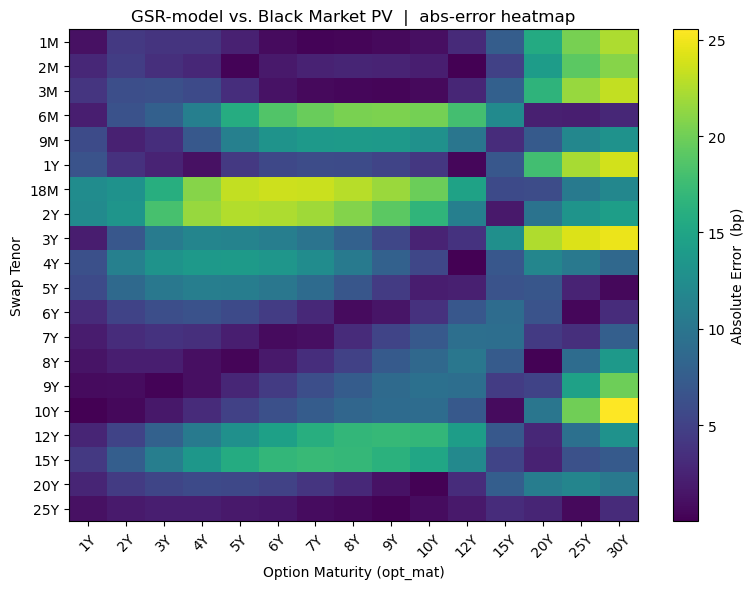

In [24]:
black_df["abs_err_bp(GSR)"] = black_df.apply(
        lambda r: abs(
            GSR_pv(discount_curve, r.opt_mat, r.swap_tenor, a_GSR_opt, sigma_GSR_opt, vol_times) -
            black_pv(discount_curve, r.opt_mat, r.swap_tenor, r.sigmaB_pct*1e-2)
        ) * 1e4,    # → bp
        axis=1
    ).copy()    

heat = black_df.pivot_table(index="opt_mat",columns="swap_tenor",values="abs_err_bp(GSR)")
opt_mat_order = ["1M", "2M", "3M", "6M", "9M", "1Y", "18M", "2Y", "3Y",
 "4Y", "5Y", "6Y", "7Y", "8Y", "9Y", "10Y", "12Y", "15Y", "20Y", "25Y"]
swap_tenor_order = [ "1Y",  "2Y", "3Y", "4Y", "5Y", "6Y", "7Y", "8Y", "9Y",
 "10Y", "12Y", "15Y", "20Y", "25Y", "30Y"]
heat = heat.reindex(opt_mat_order)
heat = heat.reindex(columns=swap_tenor_order)


fig, ax = plt.subplots(figsize=(8,6))
im = ax.imshow(heat.values, aspect="auto")
ax.set_xticks(np.arange(len(heat.columns)))
ax.set_xticklabels(heat.columns, rotation=45)
ax.set_yticks(np.arange(len(heat.index)))
ax.set_yticklabels(heat.index)
ax.set_xlabel("Option Maturity (opt_mat)")
ax.set_ylabel("Swap Tenor")
cbar = plt.colorbar(im, ax=ax)
cbar.set_label("Absolute Error  (bp)")
ax.set_title("GSR-model vs. Black Market PV  |  abs-error heatmap")
plt.tight_layout()
plt.show()

In [18]:
# ── 0)  你想测的参数 & 期限  ─────────────────────────────
a_hw     = 0.034        # 任选，也可用校准结果 a_opt
sigma_hw = 0.012       # 任选，也可用校准结果 sigma_opt
opt_mat  = "18M"        # option maturity
swap_tenor = "6Y"      # underlying swap tenor

# ── 1)  构建 Hull-White 模型  ────────────────────────────
hw = ql.HullWhite(discount_curve, a_hw, sigma_hw)

vol_dates = ql.DateVector()                       # n = 0 断点
sigma_vec = ql.QuoteHandleVector(
    [ql.QuoteHandle(ql.SimpleQuote(sigma_hw))]      # 1 段 σ
)
rev_vec   = ql.QuoteHandleVector(
    [ql.QuoteHandle(ql.SimpleQuote(a_hw))]       # 1 段 a
)
gsr = ql.Gsr(discount_curve, vol_dates, sigma_vec, rev_vec)  # ← 这就是常数 Hull-White

# ── 2) 统一的 Swaption 构造函数 (行权日 + T+2) ───────────
def build_swaption(opt_mat:str, tenor:str):
    sofr   = ql.Sofr(discount_curve)
    today  = discount_curve.referenceDate()
    opt_p  = ql.Period(str(opt_mat))
    ten_p  = ql.Period(str(tenor))

    exercise_date  = calendar.advance(today, opt_p)
    effective_date = calendar.advance(exercise_date, 2, ql.Days)    # T+2
    fwdStart       = ql.Period(int(effective_date - today), ql.Days)

    swap = ql.MakeOIS(
        ten_p, sofr,
        fixedRate=None,
        fwdStart=fwdStart,
        discountingTermStructure=discount_curve
    )
    exercise = ql.EuropeanExercise(exercise_date)

    
    return ql.Swaption(swap, exercise)

swpt = build_swaption(opt_mat, swap_tenor)

# ── 3)  Jamshidian 引擎定价  ─────────────────────────────
eng_jam = ql.JamshidianSwaptionEngine(hw, discount_curve)
swpt.setPricingEngine(eng_jam)
pv_jam  = swpt.NPV()

# ── 4)  Gaussian1d 引擎定价 (同一 HW 模型) ───────────────
eng_gauss = ql.Gaussian1dSwaptionEngine(
    gsr,               # 1: Gaussian1dModel, e.g. Gsr
    512,                      # 2: integrationPoints
    10,                     # 3: stddevs
    False,                    # 4: extrapolatePayoff
    False,                   # 5: flatPayoffExtrapolation
    discount_curve,          # 6: discountCurve
    0                        # 7: probabilities (0 = None)
)
swpt.setPricingEngine(eng_gauss)
pv_gau  = swpt.NPV()

# ── 5) 结果对比 ─────────────────────────────────────────
diff_bp = (pv_gau - pv_jam) * 1e4      # ← 差值 bp
print(f"Jamshidian PV  : {pv_jam: .10f}")
print(f"Gaussian1d  PV : {pv_gau: .10f}")
print(f"Difference     : {diff_bp: .6f}  bp")



Jamshidian PV  :  0.0274472754
Gaussian1d  PV :  0.0266137949
Difference     : -8.334805  bp


In [10]:

LOG = logging.getLogger("exposure_engine")
LOG.setLevel(logging.INFO)
if not LOG.handlers:
    ch = logging.StreamHandler()
    ch.setFormatter(logging.Formatter("%(asctime)s [%(levelname)s] %(message)s"))
    LOG.addHandler(ch)
# ---------------------------------------------------------------------------
# Helper dataclasses
# ---------------------------------------------------------------------------


@dataclass
class ExposureConfig:
    """Runtime / numerical parameters for the engine."""

    # simulation
    n_paths: int = 20_000
    seed: int = 42
    use_sobol: bool = True
    brownian_bridge: bool = True

    # time grid granularity (can be overridden per trade set)
    dt_front_weeks: int = 1  # step during option period     (in weeks)
    dt_back_months: int = 1  # step during underlying swap   (in months)

    # exposure statistics
    pfe_quantile: float = 0.95

     # misc
    logger: logging.Logger = field(default=LOG)
   
# ---------------------------------------------------------------------------
# Core Engine
# ---------------------------------------------------------------------------

class ExposureEngine:
    """Engine that generates HW‑1F paths and computes EE/PFE for SOFR swaptions."""

    def __init__(
        self,
        discount_curve: ql.YieldTermStructureHandle,
        a: float,
        sigma: float,
        payer: int = 1,
        config: Optional[ExposureConfig] = None,
    ) -> None:
        
        
        self.curve = discount_curve
        self.a = a
        self.sigma = sigma
        self.payer = payer  # 1 for payer, -1 for receiver
        self.config = config or ExposureConfig()

        # Hull‑White model + process (for bond pricing & closed forms)
        self.model = ql.HullWhite(self.curve, a, sigma)
        self.process = ql.HullWhiteProcess(self.curve, a, sigma)

        self.calendar = self.curve.calendar()
        self.today = self.curve.referenceDate()
        self.dc = self.curve.dayCounter()

        self.config.logger.info(
            "ExposureEngine initialised  |  a = %.6f, sigma = %.6f  |  paths = %d",
            self.a,
            self.sigma,
            self.config.n_paths,
        )

    

    # ---------------------------------------------------------------------
    #  Internal helpers
    # ---------------------------------------------------------------------

    def _build_time_grid(
        self,
        exercise_date: ql.Date,
        maturity_date: ql.Date,
        cfg: ExposureConfig,
    ) -> Tuple[List[ql.Date], np.ndarray, int]:
        """Concatenate option period (weekly) + swap period (monthly) grids."""

        # option period (weekly)
        front_dates: List[ql.Date] = []
        d = self.today
        while d < exercise_date:
            front_dates.append(d)
            d = self.calendar.advance(d, ql.Period(cfg.dt_front_weeks, ql.Weeks))
        front_dates.append(exercise_date)

        # swap period (monthly)
        back_dates: List[ql.Date] = []
        d = exercise_date
        while d < maturity_date:
            d = self.calendar.advance(d, ql.Period(cfg.dt_back_months, ql.Months))
            back_dates.append(d)
        if back_dates[-1] != maturity_date:
            back_dates.append(maturity_date)

        all_dates: List[ql.Date] = front_dates + back_dates
        grid_times = np.array([self.dc.yearFraction(self.today, dt) for dt in all_dates])
        idx_exercise = len(front_dates) - 1  # inclusive index of exercise date

        cfg.logger.debug("Time grid built with %d nodes", len(grid_times))
        return all_dates, grid_times, idx_exercise

    # .....................................................................

    def _simulate_short_rate_paths(
        self,
        grid_times: np.ndarray,
        n_paths: int,
        cfg: ExposureConfig,
    ) -> np.ndarray:
        """Generate Hull‑White short‑rate paths on the provided time grid."""
        dt_vector = np.diff(grid_times, prepend=0.0)
        n_steps = len(grid_times)   

        # Sobol / Pseudo RNG
        if cfg.use_sobol:
            dim = n_steps - 1  # increments count
            sobol = ql.SobolBrownianGenerator(dim, cfg.seed, cfg.brownian_bridge)
            generator = ql.SobolBrownianGeneratorFactory().create(dim, cfg.seed, cfg.brownian_bridge)
        else:
            generator = ql.GaussianRandomSequenceGenerator(
                ql.UniformRandomSequenceGenerator(n_steps - 1, ql.UniformRandomGenerator(cfg.seed))
            )

        pathgen = ql.GaussianPathGenerator(self.process, ql.TimeGrid(list(grid_times)), generator, False)

        paths = np.empty((n_paths, n_steps), dtype=float)
        for i in range(n_paths):
            s = pathgen.next()
            values = s.value()
            paths[i, :] = np.array([values[j] for j in range(n_steps)])
        return paths

    # .....................................................................

    # .....................................................................
    
    def _price_swaption_pathwise(self, swaption: ql.Swaption, grid_times: np.ndarray, grid_dates: np.ndarray, r_sub: np.ndarray) -> np.ndarray:
        """Path‑wise swaption valuation using Jamshidian + path‑consistent curve.

        Notes
        -----
        For each path i and node t_j:
        1. Compute *realised* discount factor  D_path(0,t_j)=exp(-∑ rΔt)
        2. For every pillar T≥t_j  build   P_sim(0,T)=D_path(0,t_j)*P_HW(t_j,T;r_{t_j})
           where  P_HW  is Hull‑White closed‑form  P(t,T)=A·exp(-B r_t).
        3. Create a DiscountCurve from {T,P_sim} and link it to a dummy handle
           already used by JamshidianSwaptionEngine.
        4. Engine returns PV_0 ; convert to node PV_t = PV_0 / D_path(0,t_j).
        """
        n_paths, n_steps = r_sub.shape
        results = np.empty_like(r_sub)

        # underlying swap & pillar dates ----------------------------------
        under_swap: ql.Swap = swaption.underlying()

        pillar_dates = {swaption.exercise().dates()[0]}
        pillar_dates.update(cf.date() for cf in under_swap.fixedLeg())
        pillar_dates.update(cf.date() for cf in under_swap.floatingLeg())
        pillar_dates = sorted(d for d in pillar_dates if d > self.today)
        tau_pillar = np.array([self.dc.yearFraction(self.today, d) for d in pillar_dates])

        # independent handle (affects discounting only) -----------------------------
        discH = ql.RelinkableYieldTermStructureHandle()
        discH.linkTo(self.curve.currentLink())
        engine = ql.JamshidianSwaptionEngine(self.model, discH)
        swaption.setPricingEngine(engine)
        
        # pre‑compute dt grid for path discount
        dt_vec = np.diff(grid_times, prepend=0.0)

        for j, t in enumerate(grid_times):
            # accumulate realised discount exp(-∑ rΔt) up to node j  (vectorised over paths)
            if j == 0:
                disc_path = np.ones(n_paths)
            else:
                disc_path *= np.exp(-r_sub[:, j] * dt_vec[j])

            for i in range(n_paths):
                r_t = r_sub[i, j]
                discounts = []
                for k, d in enumerate(pillar_dates):


                    P_tT = self.model.discountBond(t, tau_pillar[k], r_t)  # P_HW(t,T;r_t)
                    discounts.append(disc_path[i] * P_tT)

                full_dates     = [self.today] + pillar_dates
                full_discounts = [1.0]       + discounts
                sim_curve      = ql.DiscountCurve(full_dates, full_discounts, self.dc, self.calendar)
                discH.linkTo(sim_curve) # fixed rate for swap dont change here, only discount curve and HW'S theta changes

                PV0 = swaption.NPV()          # present value at t0
                results[i, j] = PV0 / disc_path[i]  # convert to node t value
        return results

    # .....................................................................

    def _price_swap_pathwise(
        self,
        swap: ql.Swap,
        times: np.ndarray,
        r_subpaths: np.ndarray,
    ) -> np.ndarray:
        """Closed-form valuation of fixed-vs-float OIS under Hull-White.
        兼容旧版 QuantLib：若 Swap 无 legRate()，则从首张 FixedRateCoupon 取固定利率。
        公式：V(t)=P(t,T0)−P(t,Tn)−K Σ δ_i P(t,T_i)
        """
        n_paths, _ = r_subpaths.shape
        results = np.empty_like(r_subpaths)

        notional = swap.nominal()
        # 固定利率
        
        fixed_rate = swap.fixedRate()

        schedule  = swap.fixedSchedule()         # QuantLib 返回的 DateVector
        pillar_dates = list(schedule)               # e.g. [T0, T1, T2, …, Tn]

        # 用 DayCounter 把相邻付息日差转换成年化计息长度
        accruals = np.array([
            self.dc.yearFraction(pillar_dates[k-1], pillar_dates[k])
            for k in range(1, len(pillar_dates))
        ])
        T_i = np.array([self.dc.yearFraction(self.today, d) for d in pillar_dates[1:]])  # [T1, T2, …, Tn]

        for j, t in enumerate(times):
            mask   = list(T_i >= t)
            delta  = np.array(accruals)[mask]       
            tau_i  = T_i[mask] - t

            if len(tau_i) != 0:
                for i in range(n_paths):
                    P_t_Ti = [self.model.discountBond(t, T_ii, r_subpaths[i, j]) for T_ii in T_i[mask]]
                    value = notional * (P_t_Ti[0] - P_t_Ti[-1] - fixed_rate * np.dot(delta, P_t_Ti))
                    results[i, j] = value
            else:
                # no future cash flows, value is zero
                results[:, j] = 0.0
        return results

    # .....................................................................

    
    # ---------------------------------------------------------------------
    #  Public API
    # ---------------------------------------------------------------------

    def exposure_sofr_swaption(
        self,
        swaption: ql.Swaption,
        n_paths: Optional[int] = None,
        pfe_quantile: Optional[float] = None,
    ) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
        """Monte‑Carlo EE / PFE paths for a *physical* European SOFR OIS swaption.

        Parameters
        ----------
        swaption : ql.Swaption
            Must be *physical delivery* style (default in QuantLib).
        n_paths : int, optional
            Number of Monte‑Carlo scenarios.  Overrides config if given.
        pfe_quantile : float, optional
            Tail quantile for PFE (default 95%).

        Returns
        -------
        grid_times : ndarray (N,)
            Year fractions from today to last coupon date.
        EE : ndarray (N,)
            Expected exposure at each grid node.
        PFE : ndarray (N,)
            Positive‑tail exposure (quantile) at each grid node.
        """
        cfg = self.config
        n_paths = n_paths or cfg.n_paths
        pfe_q = pfe_quantile or cfg.pfe_quantile

        exercise_date: ql.Date = swaption.exercise().dates()[0]
        underlying: ql.Swap = swaption.underlying()
        maturity_date: ql.Date = underlying.maturityDate()

        # 1) build simulation time grid ------------------------------------------------
        grid_dates, grid_times, idx_exercise = self._build_time_grid(
            exercise_date, maturity_date, cfg
        )

        # 2) HW path generation --------------------------------------------------------
        r_paths = self._simulate_short_rate_paths(grid_times, n_paths, cfg)


        # 3) Pathwise repricing --------------------------------------------------------
        swaption_values = np.zeros((n_paths, len(grid_times[: idx_exercise + 1])), dtype=np.float64)
        swap_values = np.zeros((n_paths, len(grid_times)), dtype=np.float64)

        # --- 3.1 swaption value prior to exercise
        swaption_values[:, :] = self._price_swaption_pathwise(
            swaption, grid_times[: idx_exercise + 1], grid_dates[: idx_exercise + 1], r_paths[:, : idx_exercise + 1]
        )

      
        swap_values[:,:] = self._price_swap_pathwise(
            underlying,
            grid_times,       
            r_paths
        )                               
        swap_npv_at_ex = swaption_values[:, idx_exercise]  # NPV at exercise date

        # 2) 行权标志：根据 swap NPV 正负，带容差
        tol = 1e-8
        exercised = (self.payer * swap_npv_at_ex) > tol

        cfg.logger.info(
            "Pathwise exercise probability = %.4f",
            exercised.mean(),
        )

    

        # 4) EE / PFE --------------------------------------------------------
        # values.shape = (n_paths, n_grid)   —— 早就算好的路径市值矩阵
        pos   = np.maximum(swaption_values, 0.0)
        neg   = np.minimum(swaption_values, 0.0)

        EE      = pos.mean(axis=0)                 # 已有
        PFE_95  = np.quantile(pos, 0.95, axis=0)

        # ⬇ 新增
        ENE     = neg.mean(axis=0)

        # Effective EE: running max
        EEE     = np.maximum.accumulate(EE)
        EAD     = EEE.max()                         # 一个标量

        PFE_99  = np.quantile(pos, 0.99, axis=0)

        # bilateral VAR-like 区间
        VAR_low  = np.quantile(swaption_values, 0.025, axis=0)
        VAR_high = np.quantile(swaption_values, 0.975, axis=0)

        return grid_dates, grid_times, idx_exercise, swaption_values, swap_values, r_paths, EE, EEE, EAD, ENE, PFE_95, PFE_99, VAR_low, VAR_high,swap_npv_at_ex


def swap_cashflows_df(swap: ql.Swap) -> pd.DataFrame:
    rows = []
    leg_labels = ["Fixed", "Float"]
    for leg_idx, leg_name in enumerate(leg_labels):
        for cf in swap.leg(leg_idx):
            row = {
                "Leg"      : leg_name,
                "PayDate"  : cf.date().ISO(),
                "Amount"   : cf.amount(),
            }
            if isinstance(cf, ql.Coupon):
                row.update({
                    "Start"  : cf.accrualStartDate().ISO(),
                    "End"    : cf.accrualEndDate().ISO(),
                    "Accrual": cf.accrualPeriod(),
                    "Rate"   : getattr(cf, "rate", lambda: None)(),  # fixed rate or index fixing
                })
            rows.append(row)
    return pd.DataFrame(rows)


In [61]:
def swap_cashflows_df(swap: ql.Swap) -> pd.DataFrame:
    rows = []
    leg_labels = ["Fixed", "Float"]
    for leg_idx, leg_name in enumerate(leg_labels):
        for cf in swap.leg(leg_idx):
            row = {
                "Leg"      : leg_name,
                "PayDate"  : cf.date().ISO(),
                "Amount"   : cf.amount(),
            }
            if isinstance(cf, ql.Coupon):
                row.update({
                    "Start"  : cf.accrualStartDate().ISO(),
                    "End"    : cf.accrualEndDate().ISO(),
                    "Accrual": cf.accrualPeriod(),
                    "Rate"   : getattr(cf, "rate", lambda: None)(),  # fixed rate or index fixing
                })
            rows.append(row)
    return pd.DataFrame(rows)

opt_mat = ql.Period("6M")        # 举例：6 个月期权
swap_tenor = ql.Period("5Y")     # 5Y SOFR OIS
exercise_date = calendar.advance(today, opt_mat)
effective_date = calendar.advance(exercise_date, ql.Period(2, ql.Days))
days_to_start = effective_date - today
fwdStart = ql.Period(int(days_to_start), ql.Days)

sofr = ql.Sofr(discount_curve)
swap = ql.MakeOIS(
    swap_tenor, sofr,
    fixedRate=None,                # None => ATM
    fwdStart=fwdStart,
    discountingTermStructure=discount_curve
)

swaption = ql.Swaption(
    swap, ql.EuropeanExercise(exercise_date)
)

schedule  = swap.fixedSchedule()         # QuantLib 返回的 DateVector
pay_dates = list(schedule)               # e.g. [T0, T1, T2, …, Tn]

# 用 DayCounter 把相邻付息日差转换成年化计息长度
dc = swap.dayCounter() if hasattr(swap, "dayCounter") else ql.Actual365Fixed()

accruals = np.array([
    dc.yearFraction(pay_dates[k-1], pay_dates[k])
    for k in range(1, len(pay_dates))
])
print(swap_cashflows_df(swap))
print(list(schedule))
accruals[accruals >=1]

     Leg     PayDate    Amount
0  Fixed  2027-02-02  0.035404
1  Fixed  2028-02-02  0.035404
2  Fixed  2029-02-02  0.035501
3  Fixed  2030-02-04  0.035598
4  Fixed  2031-02-03  0.035307
5  Float  2027-02-02  0.035688
6  Float  2028-02-02  0.032243
7  Float  2029-02-02  0.035629
8  Float  2030-02-04  0.036204
9  Float  2031-02-03  0.037735
[Date(2,2,2026), Date(2,2,2027), Date(2,2,2028), Date(2,2,2029), Date(4,2,2030), Date(3,2,2031)]


array([1.        , 1.        , 1.00273973, 1.00547945])

2025-08-07 09:49:06,168 [INFO] ExposureEngine initialised  |  a = 0.023286, sigma = 0.500000  |  paths = 5000
2025-08-07 09:49:46,756 [INFO] Pathwise exercise probability = 1.0000


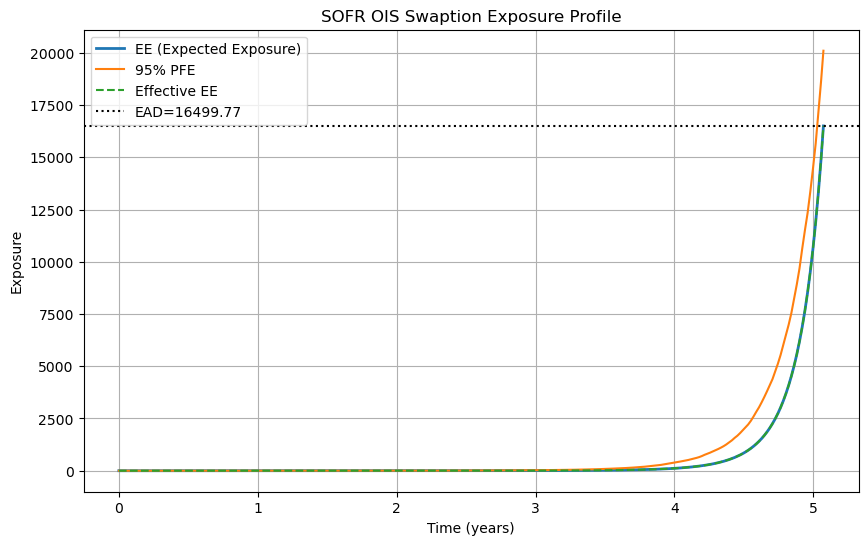

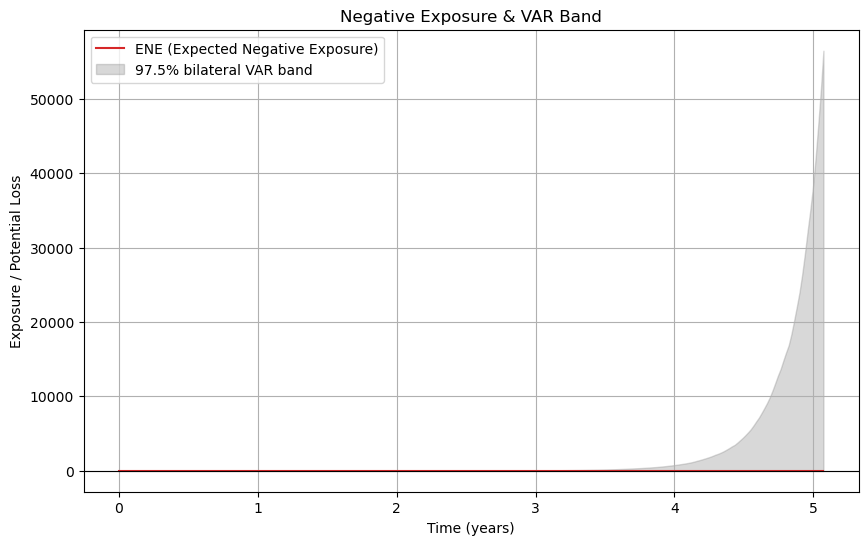

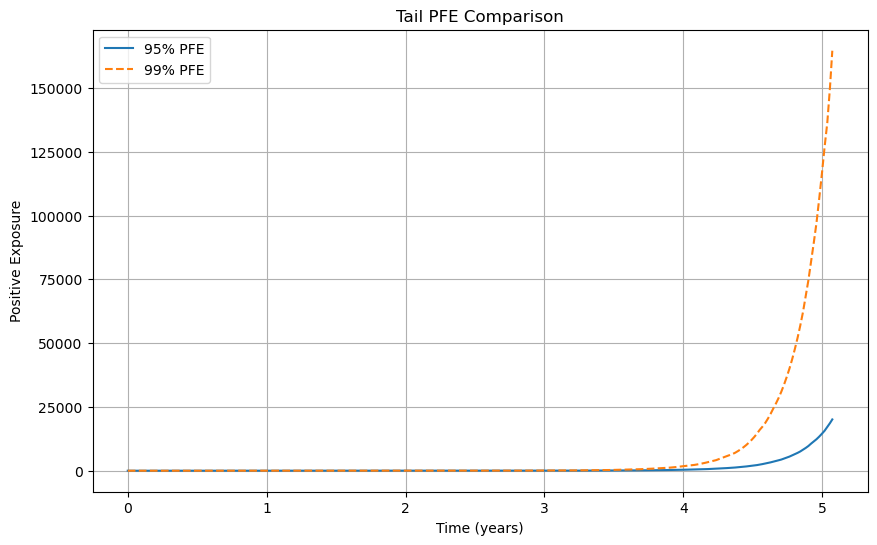

First 5 EE points  : [0.71059172 0.7111948  0.71178934 0.71240228 0.71302518]
First 5 PFE_95 pts : [0.71059172 0.7127567  0.71533542 0.71841113 0.72189439]
EAD (max EEE)      : 16499.77425239244


In [9]:
opt_mat = ql.Period("5Y")        # 举例：6 个月期权
swap_tenor = ql.Period("3Y")     # 5Y SOFR OIS
exercise_date = calendar.advance(today, opt_mat)
effective_date = calendar.advance(exercise_date, ql.Period(2, ql.Days))
days_to_start = effective_date - today
fwdStart = ql.Period(int(days_to_start), ql.Days)

sofr = ql.Sofr(discount_curve)
swap = ql.MakeOIS(
    swap_tenor, sofr,
    fixedRate=None,                # None => ATM
    fwdStart=fwdStart,
    discountingTermStructure=discount_curve
)

swaption = ql.Swaption(
    swap, ql.EuropeanExercise(exercise_date)
)

# ---------------------------------------------------------------------
# 4. Monte-Carlo 敞口计算
# ---------------------------------------------------------------------
cfg = ExposureConfig(
    n_paths=5000,          # 路径数
    dt_front_weeks=1,
    dt_back_months=1,
    use_sobol=False,
    brownian_bridge=True
)

eng = ExposureEngine(discount_curve, a_HW_opt, 0.5, config=cfg)

grid_dates, grid_times, idx_exercise, swaption_values, swap_values, r_paths, EE, EEE, EAD, ENE, PFE_95, PFE_99, VAR_low, VAR_high,swap_npv_at_ex  = eng.exposure_sofr_swaption(swaption)

# ---------------------------------------------------------------------
# 5. 结果展示
# ---------------------------------------------------------------------
# ------------------------------------------------------------
# 1. 主敞口曲线：EE / PFE95 / EEE
# ------------------------------------------------------------
plt.figure(figsize=(10, 6))
plt.plot(grid_times[:idx_exercise+1], EE,        label="EE (Expected Exposure)", lw=2)
plt.plot(grid_times[:idx_exercise+1], PFE_95,    label="95% PFE",                lw=1.5)
plt.plot(grid_times[:idx_exercise+1], EEE,       label="Effective EE",           lw=1.5, ls="--")
plt.axhline(EAD, ls=":", color="k", label=f"EAD={EAD:.2f}")
plt.xlabel("Time (years)")
plt.ylabel("Exposure")
plt.title("SOFR OIS Swaption Exposure Profile")
plt.legend()
plt.grid(True)
plt.show()

# ------------------------------------------------------------
# 2. 负向敞口与 VAR 区间
# ------------------------------------------------------------
plt.figure(figsize=(10, 6))
plt.plot(grid_times[:idx_exercise+1], ENE, label="ENE (Expected Negative Exposure)", color="tab:red")
# VAR 区间用填充阴影
plt.fill_between(grid_times[:idx_exercise+1], VAR_low, VAR_high, color="grey", alpha=0.3,
                 label="97.5% bilateral VAR band")
plt.axhline(0, color="k", lw=0.8)
plt.xlabel("Time (years)")
plt.ylabel("Exposure / Potential Loss")
plt.title("Negative Exposure & VAR Band")
plt.legend()
plt.grid(True)
plt.show()

# ------------------------------------------------------------
# 3. 99% PFE 对比
# ------------------------------------------------------------
plt.figure(figsize=(10, 6))
plt.plot(grid_times[:idx_exercise+1], PFE_95, label="95% PFE")
plt.plot(grid_times[:idx_exercise+1], PFE_99, label="99% PFE", ls="--")
plt.xlabel("Time (years)")
plt.ylabel("Positive Exposure")
plt.title("Tail PFE Comparison")
plt.legend()
plt.grid(True)
plt.show()

# ------------------------------------------------------------
# 4. 打印关键数值
# ------------------------------------------------------------
print("First 5 EE points  :", EE[:5])
print("First 5 PFE_95 pts :", PFE_95[:5])
print("EAD (max EEE)      :", EAD)

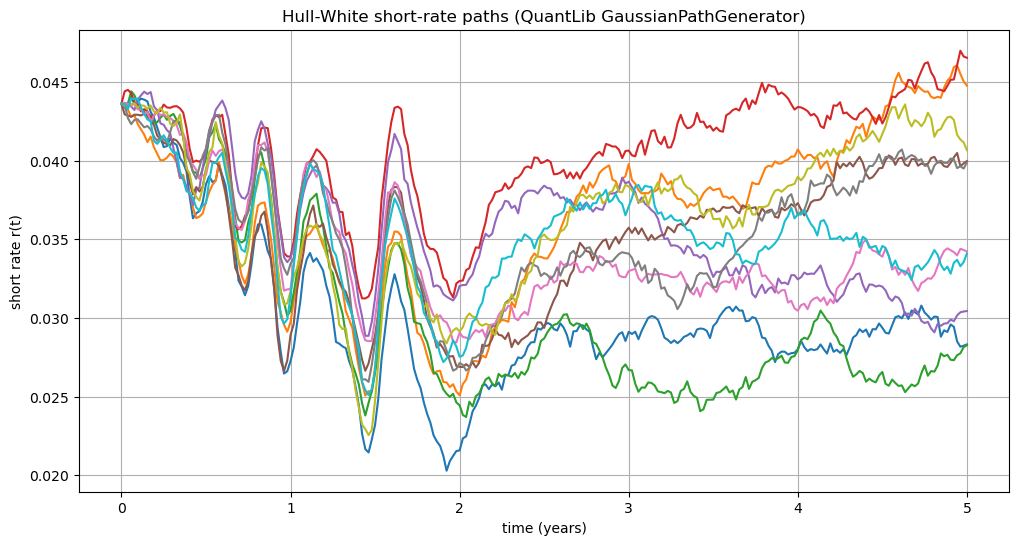

In [ ]:
# 1. 市场与模型参数
# ------------------------------------------------------------
a      = a_HW_opt          # 均值回复速度
sigma  = sigma_HW_opt          # 波动率

# Hull-White 过程（解析一步分布）
hw_process = ql.HullWhiteProcess(discount_curve, a, sigma)

# ------------------------------------------------------------
# 2. 时间网格：5 年，周步长
# ------------------------------------------------------------
T_years    = 5.0
n_steps    = int(T_years * 52)          # 52≈一年周数
times      = np.linspace(0.0, T_years, n_steps + 1)  # t_0=0  … t_n
time_grid  = ql.TimeGrid(list(times))

# ------------------------------------------------------------
# 3. 随机数发生器 → GaussianPathGenerator
# ------------------------------------------------------------
dim   = len(time_grid) - 1              # 需要的正态增量维度
seed  = 42

ursg  = ql.UniformRandomSequenceGenerator(dim,
                                          ql.UniformRandomGenerator(seed))
gsg   = ql.GaussianRandomSequenceGenerator(ursg)      # 伪随机 N(0,1)
pathgen = ql.GaussianPathGenerator(hw_process,
                                   time_grid,
                                   gsg,
                                   False)             # BrownianBridge=False

# ------------------------------------------------------------
# 4. 生成路径
# ------------------------------------------------------------
n_paths = 10
paths   = np.empty((n_paths, len(time_grid)))

for i in range(n_paths):
    sample = pathgen.next()             # 取一条完整路径
    ql_array = sample.value()           # QuantLib Array
    paths[i, :] = [ql_array[j] for j in range(len(time_grid))]

# ------------------------------------------------------------
# 5. 画图
# ------------------------------------------------------------
plt.figure(figsize=(12, 6))
plt.plot(times, paths.T)
plt.title("Hull-White short-rate paths (QuantLib GaussianPathGenerator)")
plt.xlabel("time (years)")
plt.ylabel("short rate r(t)")
plt.grid(True)
plt.show()